In [2]:
ver = 'linear_v34'
import warnings
warnings.filterwarnings('ignore')

import gc
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import time
from datetime import datetime

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, SGDClassifier
from sklearn.feature_selection import RFECV

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, confusion_matrix
import os
print(os.listdir("../input"))

from hyperopt import fmin, tpe, hp, anneal, Trials, STATUS_OK

RANDOM_STATE = 78
noise_std = 0.01

['test.csv', 'train.csv', 'sample_submission.csv']


**Submission**

In [3]:
filename = 'subm_{}_{}_'.format(ver, datetime.now().strftime('%Y-%m-%d'))

def sub_prp(clf, filename, X_test):
    prediction_ = clf.predict_proba(X_test)[:,1]
    submission_ = pd.read_csv('../input/sample_submission.csv')
    submission_['target'] = prediction_
    submission_.to_csv(filename, index=False)
    print(submission_.head())
    
def sub_pr(clf, filename, X_test):
    prediction_ = clf.predict(X_test)
    submission_ = pd.read_csv('../input/sample_submission.csv')
    submission_['target'] = prediction_
    submission_.to_csv(filename, index=False)
    print(submission_.head())

**Load datasets**

In [4]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [5]:
train.shape, test.shape

((250, 302), (19750, 301))

In [6]:
train.describe()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,124.500000,0.640000,0.023292,-0.026872,0.167404,0.001904,0.001588,-0.007304,0.032052,0.078412,-0.036920,0.035448,-0.005032,0.110248,0.019808,-0.001108,-0.016280,-0.039644,0.017260,-0.106856,0.036184,-0.043296,-0.110832,0.072680,0.017296,-0.030728,-0.128252,0.154736,0.083408,0.039552,-0.091784,0.054636,-0.048288,-0.017296,0.007708,-0.134460,0.093852,-0.020588,-0.002492,-0.141400,...,0.005780,-0.102304,-0.013796,0.089384,0.036368,0.016276,-0.069448,-0.113236,0.035696,0.034484,-0.066236,-0.057988,0.091556,-0.029896,0.115648,0.007372,0.033552,0.090524,0.001576,-0.007784,0.043184,0.082696,0.098476,0.055356,0.111708,-0.015688,0.035992,0.026452,-0.059152,0.077272,0.044652,0.126344,0.018436,-0.012092,-0.065720,-0.106112,0.046472,0.006452,0.009372,-0.128952
std,72.312977,0.480963,0.998354,1.009314,1.021709,1.011751,1.035411,0.955700,1.006657,0.939731,0.963688,1.019689,1.085089,1.036265,1.050041,1.024305,0.926789,0.955915,1.025655,1.012777,0.945099,1.055935,1.003178,1.039556,0.988482,0.945902,0.997026,0.997894,1.040371,0.922270,1.047282,1.041432,1.010971,0.992464,0.986350,1.015563,1.117898,0.958191,0.948855,1.042429,...,0.994761,1.094494,1.026025,0.963489,1.026373,1.008207,0.989451,1.002857,0.944743,1.023709,0.985451,0.951879,1.027877,0.966882,1.037173,1.004543,1.006219,1.037119,1.024067,1.056086,1.012516,1.068741,0.934163,0.988100,1.043230,1.010720,1.058982,0.896318,1.113760,0.972530,1.011416,0.972567,0.954229,0.960630,1.057414,1.038389,0.967661,0.998984,1.008099,0.971219
min,0.000000,0.000000,-2.319000,-2.931000,-2.477000,-2.359000,-2.566000,-2.845000,-2.976000,-3.444000,-2.768000,-2.361000,-3.302000,-2.851000,-2.681000,-2.596000,-3.275000,-3.512000,-2.476000,-3.619000,-2.428000,-3.229000,-3.024000,-2.775000,-2.962000,-2.490000,-3.107000,-2.943000,-2.933000,-2.942000,-2.957000,-2.911000,-2.568000,-2.649000,-3.031000,-2.913000,-3.265000,-2.372000,-3.037000,-3.340000,...,-2.512000,-2.873000,-2.549000,-2.721000,-2.578000,-2.239000,-3.046000,-2.755000,-2.507000,-3.369000,-2.448000,-2.771000,-2.903000,-2.522000,-2.759000,-2.915000,-2.618000,-3.623000,-2.673000,-3.229000,-2.537000,-2.748000,-2.850000,-2.577000,-2.973000,-2.709000,-3.605000,-2.357000,-2.904000,-2.734000,-2.804000,-2.443000,-2.757000,-2.466000,-3.287000,-3.072000,-2.634000,-2.776000,-3.211000,-3.500000
25%,62.250000,0.000000,-0.644750,-0.739750,-0.425250,-0.686500,-0.659000,-0.643750,-0.675000,-0.550750,-0.689500,-0.643500,-0.693500,-0.524000,-0.708500,-0.692000,-0.677000,-0.634500,-0.683500,-0.801500,-0.574250,-0.758000,-0.870500,-0.596000,-0.725750,-0.652000,-0.779500,-0.424250,-0.585750,-0.625000,-0.751250,-0.582500,-0.713500,-0.750000,-0.588000,-0.829000,-0.648500,-0.659750,-0.614000,-0.816750,...,-0.622750,-1.009250,-0.693250,-0.567750,-0.696500,-0.684000,-0.703750,-0.771250,-0.624500,-0.653000,-0.786750,-0.701000,-0.54

Text(0.5, 1.0, 'Target')

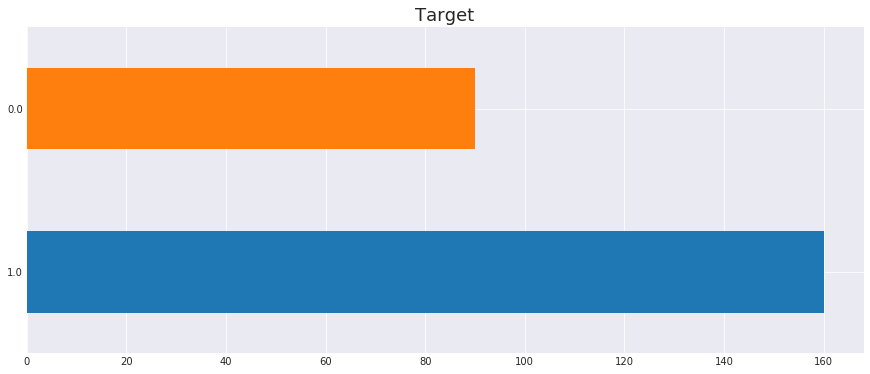

In [7]:
train['target'].value_counts().sort_index(ascending=False).plot(kind='barh', figsize=(15,6))
plt.title('Target', fontsize=18)

**Data preparation**

In [8]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_tst = test.drop(['id'], axis=1)

In [9]:
sc0 = StandardScaler()
sc0.fit(X_train)
X_train = sc0.transform(X_train)
X_test = sc0.transform(X_tst)


In [15]:
X_train += np.random.normal(0, noise_std, X_train.shape)

In [16]:
#kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
repfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=20, random_state=RANDOM_STATE)
logreg0 = LogisticRegression(C=0.5, random_state=RANDOM_STATE, solver='liblinear', penalty='l1')
lass0 = Lasso(alpha=0.031, tol=0.01, selection='random', random_state=RANDOM_STATE)
ridg0 = Ridge(alpha=20, fit_intercept=True, solver='auto', tol=0.0025, random_state=RANDOM_STATE)
sgd0 = SGDClassifier(eta0=1, max_iter=1000, tol=0.0001, random_state=RANDOM_STATE, loss='log')

**Fit simple logreg**

In [17]:
logreg0.fit(X_train, y_train)
sc = cross_val_score(logreg0, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s


0.7841666666666666


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.0s finished


In [18]:
perm = PermutationImportance(logreg0, random_state=RANDOM_STATE).fit(X_train, y_train)
eli5.show_weights(perm, top=10)

Weight,Feature
0.1064 ± 0.0306,x33
0.0696 ± 0.0180,x65
0.0272 ± 0.0093,x91
0.0264 ± 0.0096,x217
0.0216 ± 0.0109,x73
0.0120 ± 0.0072,x199
0.0112 ± 0.0093,x82
0.0096 ± 0.0130,x295
0.0064 ± 0.0064,x117
0.0024 ± 0.0039,x46


In [19]:
top_feat = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(perm).feature]
top_feat1 = top_feat[:15]
top_feat1.append('target')
corr = train[top_feat1].corr()
corr.target.sort_values(ascending=False)

target    1.000000
33        0.373608
65        0.293846
24        0.173096
199       0.159442
17        0.110998
46        0.074598
69        0.004514
108      -0.113875
82       -0.128248
258      -0.138332
73       -0.167557
295      -0.170501
91       -0.192536
117      -0.197496
217      -0.207215
Name: target, dtype: float64

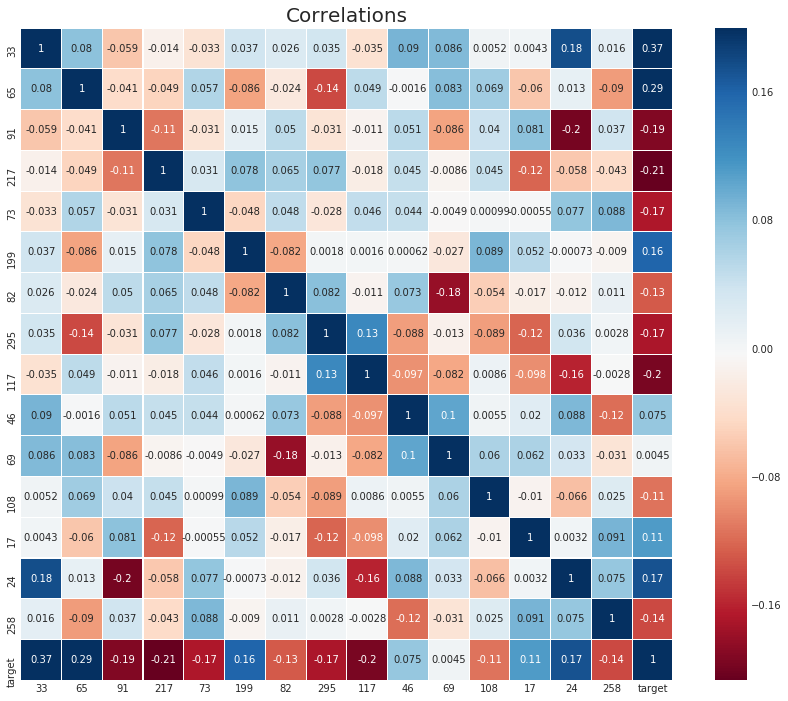

In [20]:
mask = np.zeros_like(corr, dtype=np.bool)

plt.subplots(figsize = (15,12))
sns.heatmap(corr, 
            annot=True,
            #mask = mask,
            cmap = 'RdBu',
            linewidths=0.1, 
            linecolor='white',
            vmax = .2,
            square=True)
plt.title("Correlations", y = 1.03,fontsize = 20);

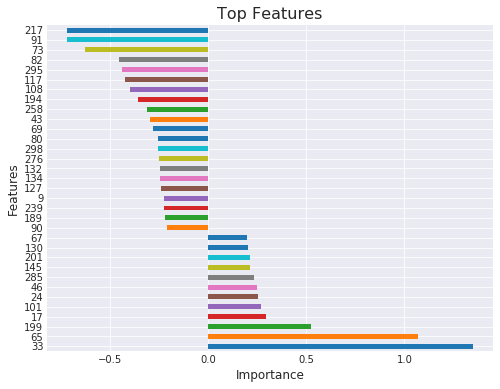

In [21]:
el_df =pd.Series(logreg0.coef_[0], index=range(len(X_train.T)))
el_df = el_df[(logreg0.coef_[0]<=-0.2) | (logreg0.coef_[0]>=0.2)].sort_values(ascending=False)
plt.figure(figsize=(8,6))
el_df.plot(kind='barh')
plt.xlabel("Importance",fontsize=12)
plt.ylabel("Features",fontsize=12)
plt.title("Top Features",fontsize=16)
plt.show()

In [22]:
el_df.index

Int64Index([ 33,  65, 199,  17, 101,  24,  46, 285, 145, 201, 130,  67,  90,
            189, 239,   9, 127, 134, 132, 276, 298,  80,  69,  43, 258, 194,
            108, 117, 295,  82,  73,  91, 217],
           dtype='int64')

In [23]:
logreg01 = LogisticRegression(C=0.5, random_state=RANDOM_STATE, solver='liblinear', penalty='l1')

In [24]:
logreg01.fit(X_train.T[el_df.index].T, y_train)
sc = cross_val_score(logreg01, X_train.T[el_df.index].T, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


0.9483333333333335


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished


**Hyperparameters search for logreg with *GridSearchCV***

In [ ]:
param_lr = {'class_weight' : ['balanced', None], 
                'penalty' : ['l2','l1'],  
                'C' : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
           }

In [ ]:
grid_lr = GridSearchCV(estimator = logreg0, param_grid = param_lr , scoring = 'roc_auc', verbose = 1, n_jobs = -1, cv=repfold)

grid_lr.fit(X_train,y_train)

print("Best Score:" + str(grid_lr.best_score_))
print("Best Parameters: " + str(grid_lr.best_params_))


In [ ]:
best_parameters_lr = grid_lr.best_params_
logreg = LogisticRegression(**best_parameters_lr)
logreg.fit(X_train,y_train)
sc = cross_val_score(logreg, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

selector_lr = RFECV(logreg, min_features_to_select=12, scoring='roc_auc', step=15, verbose=0, cv=repfold, n_jobs=-1)
selector_lr.fit(X_train,y_train)
#sc = cross_val_score(selector_lr, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
#print(sc.mean())

In [ ]:
selector_lr.score(X_train, y_train)

**Hyperparameters search for logreg with *hyperopt***

In [25]:
def acc_model(params):
    clf = LogisticRegression(**params)
    return cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=repfold).mean()

In [26]:
space4lr = {'C': hp.uniform('C', .001, 50.0), 
            'solver' : hp.choice('solver', ['liblinear']),
            'penalty' : hp.choice('penalty', ['l1', 'l2']),
            #'dual' : hp.choice('dual', [True, False]),
            #'fit_intercept': hp.choice('fit_intercept', ['True', 'False']),
            'class_weight': hp.choice('class_weight', ['balanced', None]),
            'max_iter': hp.choice('max_iter', [50000]),
            'random_state': RANDOM_STATE, #hp.uniformint('random_state', 1, 100),
            #'n_jobs': -1
           }

best = 0
pr = []
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
        print ('new best:', best, params)
        pr.append(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4lr, algo=tpe.suggest, max_evals=2000, trials=trials)
print ('best for logreg: ')
print (pr[-1])

new best:                                             
0.7794097222222223                                    
{'C': 11.312904636794853, 'class_weight': None, 'max_iter': 50000, 'penalty': 'l1', 'random_state': 78, 'solver': 'liblinear'}
  0%|          | 1/2000 [00:05<3:09:22,  5.68s/it, best loss: -0.7794097222222223]


KeyboardInterrupt: 

In [29]:
print(pr[-1])
best_lr = pr[-1]
logreg1 = LogisticRegression(**best_lr)
logreg1.fit(X_train,y_train)
sc = cross_val_score(logreg1, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())


{'C': 11.312904636794853, 'class_weight': None, 'max_iter': 50000, 'penalty': 'l1', 'random_state': 78, 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s


0.7794097222222223


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.0s finished


In [ ]:
selector_lr1 = RFECV(logreg1, min_features_to_select=12, scoring='roc_auc', step=15, verbose=0, cv=repfold, n_jobs=-1)
selector_lr1.fit(X_train,y_train)
#print(selector_lr1.score(X_train, y_train))

In [ ]:
perm = PermutationImportance(logreg1, random_state=RANDOM_STATE).fit(X_train, y_train)
eli5.show_weights(perm, top=10)

In [ ]:
top_feat = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(perm).feature]
top_feat1 = top_feat[:15]
top_feat1.append('target')
corr = train[top_feat1].corr()
corr.target.sort_values(ascending=False)

In [ ]:
mask = np.zeros_like(corr, dtype=np.bool)

plt.subplots(figsize = (15,12))
sns.heatmap(corr, 
            annot=True,
            #mask = mask,
            cmap = 'RdBu',
            linewidths=0.1, 
            linecolor='white',
            vmax = .2,
            square=True)
plt.title("Correlations", y = 1.03,fontsize = 20);

**Fit simple Lasso**

In [ ]:
lass0.fit(X_train, y_train)
sc = cross_val_score(lass0, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

In [ ]:
perm = PermutationImportance(lass0, random_state=RANDOM_STATE).fit(X_train, y_train)
eli5.show_weights(perm, top=10)

In [ ]:
top_feat = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(perm).feature]
top_feat1 = top_feat[:15]
top_feat1.append('target')
corr = train[top_feat1].corr()
corr.target.sort_values(ascending=False)

In [ ]:
mask = np.zeros_like(corr, dtype=np.bool)

plt.subplots(figsize = (15,12))
sns.heatmap(corr, 
            annot=True,
            #mask = mask,
            cmap = 'RdBu',
            linewidths=0.1, 
            linecolor='white',
            vmax = .2,
            square=True)
plt.title("Correlations", y = 1.03,fontsize = 20);

In [ ]:
el_df =pd.Series(lass0.coef_,index=train.drop(['id', 'target'], axis=1).columns)
el_df = el_df[(lass0.coef_<=-0.05) | (lass0.coef_>=0.05)].sort_values(ascending=False)
plt.figure(figsize=(8,6))
el_df.plot(kind='barh')
plt.xlabel("Importance",fontsize=12)
plt.ylabel("Features",fontsize=12)
plt.title("Top Features",fontsize=16)
plt.show()

**Hyperparameters search for Lasso with *GridSearchCV***

In [ ]:
param_lass = {
            'alpha' : [0.022, 0.021, 0.02, 0.019, 0.023, 0.024, 0.025, 0.026, 0.027, 0.029, 0.031],
            'tol'   : [0.0013, 0.0014, 0.001, 0.0015, 0.0011, 0.0012, 0.0016, 0.0017]
        }

In [ ]:
grid_lass = GridSearchCV(estimator = lass0, param_grid = param_lass , scoring = 'roc_auc', verbose = 1, n_jobs = -1, cv=repfold)

grid_lass.fit(X_train,y_train)

print("Best Score:" + str(grid_lass.best_score_))
print("Best Parameters: " + str(grid_lass.best_params_))

In [ ]:
best_parameters_lass = grid_lass.best_params_
lass = Lasso(**best_parameters_lass)
lass.fit(X_train,y_train)
sc = cross_val_score(lass, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())

selector_lass = RFECV(lass, min_features_to_select=12, scoring='roc_auc', step=15, verbose=0, cv=repfold, n_jobs=-1)
selector_lass.fit(X_train,y_train)


**Hyperparameters search for Lasso with *hyperopt***

In [ ]:
def acc_model(params):
    clf = Lasso(**params)
    return cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=repfold).mean()

In [ ]:
space4lass = {'alpha' : hp.uniform('alpha', .01, 1),
            'tol'   : hp.uniform('tol', .001, 0.1),
            'random_state': RANDOM_STATE, #hp.uniformint('random_state', 1, 100),
            'max_iter': hp.choice('max_iter', [50000]),
             }

best = 0
pr = []
def f(params):
    global best
    acc = acc_model(params)
    if acc > best:
        best = acc
        print ('new best:', best, params)
        pr.append(params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space4lass, algo=tpe.suggest, max_evals=3000, trials=trials)
print ('best for lasso: ')
print (pr[-1])

In [ ]:
print(pr[-1])
best_lass = pr[-1]
lass1 = Lasso(**best_lass)
lass1.fit(X_train,y_train)
sc = cross_val_score(lass1, X_train, y_train, scoring='roc_auc', cv=repfold, n_jobs=-1, verbose=1)
print(sc.mean())


In [ ]:
selector_lass1 = RFECV(lass1, min_features_to_select=12, scoring='roc_auc', step=15, verbose=0, cv=repfold, n_jobs=-1)
selector_lass1.fit(X_train,y_train)

In [ ]:
perm = PermutationImportance(lass1, random_state=RANDOM_STATE).fit(X_train, y_train)
eli5.show_weights(perm, top=10)

In [ ]:
top_feat = [i[1:] for i in eli5.formatters.as_dataframe.explain_weights_df(perm).feature]
top_feat1 = top_feat[:15]
top_feat1.append('target')
corr = train[top_feat1].corr()
corr.target.sort_values(ascending=False)

In [ ]:
mask = np.zeros_like(corr, dtype=np.bool)

plt.subplots(figsize = (15,12))
sns.heatmap(corr, 
            annot=True,
            #mask = mask,
            cmap = 'RdBu',
            linewidths=0.1, 
            linecolor='white',
            vmax = .2,
            square=True)
plt.title("Correlations", y = 1.03,fontsize = 20);

Try function from https://www.kaggle.com/aantonova/851-logistic-regression

In [35]:
def cross_validation(train_, target_, params,
                            num_folds = 5, repeats = 20, rs = 0):
    
    print(params)
    
    clfs = []
    folds = RepeatedStratifiedKFold(n_splits = num_folds, n_repeats = repeats, random_state = rs)
    
    valid_pred = pd.DataFrame(index = train_.index)
    
    # Cross-validation cycle
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(target_, target_)):
        print('--- Fold {} started at {}'.format(n_fold, time.ctime()))
        
        train_x, train_y = train_.iloc[train_idx], target_.iloc[train_idx]
        valid_x, valid_y = train_.iloc[valid_idx], target_.iloc[valid_idx]
        
        clf = LogisticRegression(**params)
        clf.fit(train_x, train_y)
    
        clfs.append(clf)

        predict = clf.predict_proba(valid_x)[:, 1]
    
        tn, fp, fn, tp = confusion_matrix(valid_y, (predict >= .5) * 1).ravel()
        auc = roc_auc_score(valid_y, predict)
        acc = accuracy_score(valid_y, (predict >= .5) * 1)
        loss = log_loss(valid_y, predict)
        print('TN =', tn, 'FN =', fn, 'FP =', fp, 'TP =', tp)
        print('AUC = ', auc, 'Loss =', loss, 'Acc =', acc)
        
        valid_pred[n_fold] = pd.Series(predict, index = valid_x.index)

        del train_x, train_y, valid_x, valid_y, predict
        gc.collect()

    return clfs, valid_pred

def save_submit(test_, clfs_, filename):
    subm = pd.DataFrame(np.zeros(test_.shape[0]), index = test_.index, columns = ['target'])
    for clf in clfs_:
        subm['target'] += clf.predict_proba(test_)[:, 1]
    subm['target'] /= len(clfs_)
    subm = subm.reset_index()
    subm.columns = ['id', 'target']
    subm.to_csv(filename, index = False)
    #print(subm)


In [36]:
clfs, pred = cross_validation(pd.DataFrame(X_train), y_train, best_lr)

{'C': 11.312904636794853, 'class_weight': None, 'max_iter': 50000, 'penalty': 'l1', 'random_state': 78, 'solver': 'liblinear'}
--- Fold 0 started at Tue May  7 19:07:34 2019
TN = 13 FN = 10 FP = 5 TP = 22
AUC =  0.7916666666666666 Loss = 1.0564925336648938 Acc = 0.7
--- Fold 1 started at Tue May  7 19:07:34 2019
TN = 9 FN = 4 FP = 9 TP = 28
AUC =  0.7673611111111112 Loss = 0.9890408962550181 Acc = 0.74
--- Fold 2 started at Tue May  7 19:07:34 2019
TN = 10 FN = 4 FP = 8 TP = 28
AUC =  0.75 Loss = 0.9657962393968905 Acc = 0.76
--- Fold 3 started at Tue May  7 19:07:35 2019
TN = 10 FN = 9 FP = 8 TP = 23
AUC =  0.736111111111111 Loss = 1.251690664786194 Acc = 0.66
--- Fold 4 started at Tue May  7 19:07:35 2019
TN = 12 FN = 10 FP = 6 TP = 22
AUC =  0.7829861111111112 Loss = 0.9319024252099897 Acc = 0.68
--- Fold 5 started at Tue May  7 19:07:35 2019
TN = 7 FN = 8 FP = 11 TP = 24
AUC =  0.7326388888888888 Loss = 1.2212097295140893 Acc = 0.62
--- Fold 6 started at Tue May  7 19:07:35 2019
TN

TN = 9 FN = 5 FP = 9 TP = 27
AUC =  0.748263888888889 Loss = 0.9874200302071601 Acc = 0.72
--- Fold 60 started at Tue May  7 19:07:44 2019
TN = 10 FN = 7 FP = 8 TP = 25
AUC =  0.7274305555555556 Loss = 1.1087619190400306 Acc = 0.7
--- Fold 61 started at Tue May  7 19:07:44 2019
TN = 7 FN = 5 FP = 11 TP = 27
AUC =  0.7326388888888888 Loss = 1.2822430692247013 Acc = 0.68
--- Fold 62 started at Tue May  7 19:07:44 2019
TN = 12 FN = 6 FP = 6 TP = 26
AUC =  0.796875 Loss = 1.1141281958880003 Acc = 0.76
--- Fold 63 started at Tue May  7 19:07:44 2019
TN = 9 FN = 10 FP = 9 TP = 22
AUC =  0.7447916666666667 Loss = 1.166415914777921 Acc = 0.62
--- Fold 64 started at Tue May  7 19:07:44 2019
TN = 13 FN = 9 FP = 5 TP = 23
AUC =  0.7465277777777778 Loss = 1.088603350257435 Acc = 0.72
--- Fold 65 started at Tue May  7 19:07:45 2019
TN = 8 FN = 7 FP = 10 TP = 25
AUC =  0.7604166666666667 Loss = 1.054917336514212 Acc = 0.66
--- Fold 66 started at Tue May  7 19:07:45 2019
TN = 13 FN = 8 FP = 5 TP = 24

**Submission**

In [32]:
sub_prp(logreg1, filename+'lr1.csv', X_test)
sub_prp(selector_lr1, filename+'sel_lr1.csv', X_test)

    id    target
0  250  0.864178
1  251  0.017881
2  252  0.884746
3  253  1.000000
4  254  0.936852


NameError: name 'selector_lr1' is not defined

In [ ]:
sub_pr(lass1, filename+'lass1.csv', X_test)
sub_pr(selector_lass1, filename+'sel_lass1.csv', X_test)

In [37]:
save_submit(pd.DataFrame(X_test, index=test.id), clfs, filename+'lr_cv_Anna.csv')

          id    target
0        250  0.746089
1        251  0.378212
2        252  0.798515
3        253  0.999826
4        254  0.617698
5        255  0.301361
6        256  0.279069
7        257  0.317368
8        258  0.953631
9        259  0.242117
10       260  0.546617
11       261  0.266574
12       262  0.184112
13       263  0.926791
14       264  0.352298
15       265  0.926282
16       266  0.683941
17       267  0.784450
18       268  0.442608
19       269  0.714714
20       270  0.328294
21       271  0.870086
22       272  0.627557
23       273  0.690204
24       274  0.654702
25       275  0.867214
26       276  0.026147
27       277  0.975292
28       278  0.665993
29       279  0.643490
...      ...       ...
19720  19970  0.031190
19721  19971  0.974403
19722  19972  0.790324
19723  19973  0.041884
19724  19974  0.768722
19725  19975  0.751371
19726  19976  0.901679
19727  19977  0.439580
19728  19978  0.840157
19729  19979  0.999883
19730  19980  0.086509
19731  1998